In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    nb_classes = len(glob("images/train/*"))
    targets = np_utils.to_categorical(np.array(data['target']), nb_classes)
    return files, targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('images/train')
valid_files, valid_targets = load_dataset('images/valid')
test_files, test_targets = load_dataset('images/test')

# load list of classes
classes = [item[len("images/train/"):-1] for item in sorted(glob("images/train/*/"))]

# print statistics about the dataset
print('Classes:', classes)
print('Total images \t\t: ', len(np.hstack([train_files, valid_files, test_files])))
print('Training images \t: ', len(train_files))
print('Validation images \t: ', len(valid_files))
print('Test images \t\t: ', len(test_files))

Using TensorFlow backend.


Classes: ['human', 'non_human']
Total images 		:  1605
Training images 	:  783
Validation images 	:  491
Test images 		:  331


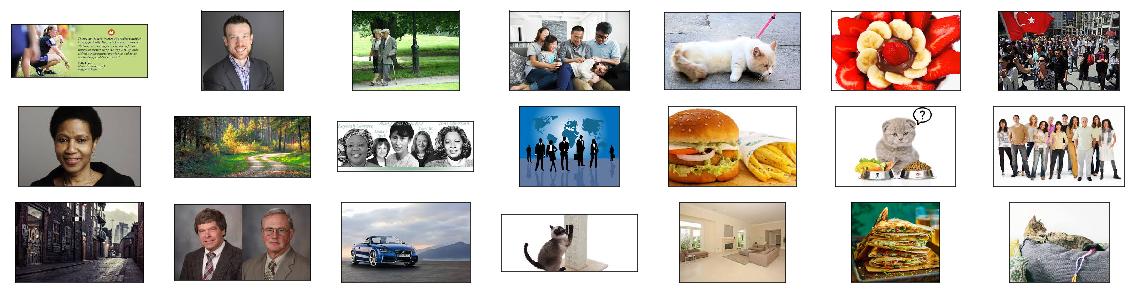

In [9]:
from PIL.Image import open
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

fig = plt.figure(figsize=(20,5))
for i in range(21):
    ax = fig.add_subplot(3, 7, i + 1, xticks=[], yticks=[])
    image = np.asarray(open(random.choice(train_files)))
    ax.imshow(image)

In [66]:
from keras.preprocessing import image  
# from tqdm import tqdm
# from tqdm import tqdm_notebook as tqdm

def path_to_tensor(img_path):
    """
    Takes a string-valued file path to a color image (3 channels) as input
    and returns a 4D tensor of shape (1, 224, 224, 3) suitable for supplying to a Keras CNN
    """
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    """
    Takes a numpy array of string-valued image paths as input 
    and returns a 4D tensor with shape (nb_samples, 224, 224, 3)
    """
    list_of_tensors = [path_to_tensor(img_path) for img_path in img_paths]
    return np.vstack(list_of_tensors)

In [67]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

In [90]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, Dropout
from keras.regularizers import l2

# ---------------------------- Model ----------------------------
# ---------------------------------------------------------------



model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224, 224, 3)))
model.add(Conv2D(filters=64, kernel_size=3, padding='same'))
model.add(Activation('relu'))
# model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
# model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=3, padding='same'))
model.add(Activation('relu'))
# model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
# model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(Conv2D(filters=256, kernel_size=3, padding='same'))
model.add(Activation('relu'))
# model.add(Conv2D(filters=256, kernel_size=3, padding='same'))
# model.add(Activation('relu'))
# model.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
# model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# model.add(Conv2D(filters=512, kernel_size=3, padding='same'))
# model.add(Activation('relu'))
# model.add(Conv2D(filters=512, kernel_size=3, padding='same'))
# model.add(Activation('relu'))
# model.add(Conv2D(filters=512, kernel_size=3, activation='relu'))
# model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# model.add(Conv2D(filters=512, kernel_size=3, padding='same'))
# model.add(Activation('relu'))
# model.add(Conv2D(filters=512, kernel_size=3, padding='same'))
# model.add(Activation('relu'))
model.add(Conv2D(filters=512, kernel_size=3, name='final_conv_layer'))
model.add(Activation('relu'))


# The model so far outputs 3D feature maps (height, width, features)

model.add(GlobalAveragePooling2D())
nb_classes = len(classes)
model.add(Dense(nb_classes, activation = 'softmax', kernel_initializer='uniform', 
                kernel_regularizer=l2(0.01), name='dense_layer'))

# ---------------------------------------------------------------
# ---------------------------------------------------------------

model.summary()

# Compilation of the Model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_2 (ZeroPaddin (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 226, 226, 64)      1792      
_________________________________________________________________
activation_28 (Activation)   (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 226, 226, 128)     73856     
_________________________________________________________________
activation_29 (Activation)   (None, 226, 226, 128)     0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 226, 226, 256)     295168    
_________________________________________________________________
activation_30 (Activation)   (None, 226, 226, 256)     0         
__________

In [91]:
# Data augmentation strategy as presented in the keras blogpost

from keras.preprocessing.image import ImageDataGenerator

batch_size = 25

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'images/train',  # this is the target directory
        target_size=(224, 224),  # all images will be resized to 224x224
        batch_size=batch_size,
        class_mode='categorical')  # since we use categorical_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'images/valid',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')

Found 783 images belonging to 2 classes.
Found 491 images belonging to 2 classes.


In [ ]:
from keras.callbacks import ModelCheckpoint  

epochs = 6

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

## Without data augmentation
# model.fit(train_tensors, train_targets, 
#           validation_data=(valid_tensors, valid_targets),
#           epochs=epochs, batch_size=batch_size, callbacks=[checkpointer], verbose=1)


history0 = model.fit_generator(train_generator,
                               steps_per_epoch=train_tensors.shape[0] // batch_size,
                               epochs=epochs, 
                               verbose=1, 
                               callbacks=[checkpointer],
                               validation_data=(valid_tensors, valid_targets),
                               validation_steps=valid_tensors.shape[0] // batch_size)

Epoch 1/6
31/31 [==============================] - 11073s 357s/step - loss: 0.8069 - acc: 0.5039 - val_loss: 0.6927 - val_acc: 0.5377
Epoch 2/6
 8/31 [======>.......................] - ETA: 23:32:59 - loss: 0.7101 - acc: 0.4900

In [71]:
import matplotlib.pyplot as plt  

def plot_history(history, filename):
    """
    plots the evolution the loss the accuracy 
    of the model on the training and validation data 
    as a function of the number of epochs  
    """
    
    plt.figure(figsize=(16, 8))
    
    # Plot accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    
    # Plot loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.savefig(filename)
    plt.show()

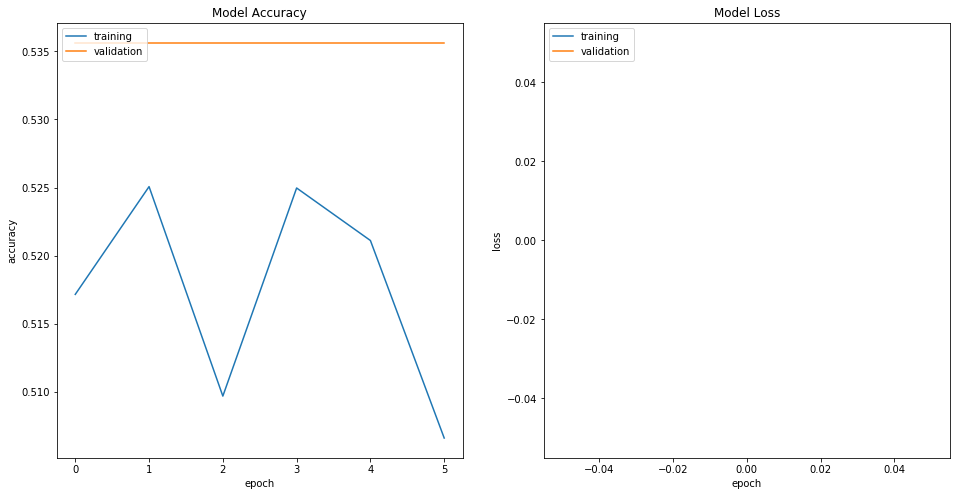

In [72]:
plot_history(history0, 'plots/history0.png')

In [ ]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

In [73]:
def compute_accuracy(model, test_tensors, test_targets):
    
    # get index of predicted class for each image in test set
    class_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

    # report test accuracy
    test_accuracy = 100*np.sum(np.array(class_predictions)==np.argmax(test_targets, axis=1))/len(class_predictions)
    print('Test accuracy: %.4f%%' % test_accuracy)

In [74]:
compute_accuracy(model, test_tensors, test_targets)

Test accuracy: 50.7553%


In [76]:
import cv2
import random

def predict(img_path):
    
    # preprocess image into resized tensor
    tensor = path_to_tensor(img_path)
    
    return np.argmax(model.predict(tensor))

def display(img_path):
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()

In [81]:
import keras.backend as K

def get_layer(model, layer_name):
    """
    returns the layer with the name 'layer_name'
    """
    layer_dict = dict([(layer.name, layer) for layer in model.layers])
    layer = layer_dict[layer_name]
    return layer


def class_activation_map(model, img_path, name_of_final_conv_layer, name_of_dense_layer, class_number):
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    width, height, _ = img.shape

    tensor = path_to_tensor(img_path)

    # Get the input weights to the dense layer.
    class_weights = get_layer(model, name_of_dense_layer).get_weights()[0]
    
    
    # Get the output of the final convolutional layer for the tensor input
    final_conv_layer = get_layer(model, name_of_final_conv_layer)
    
    get_output = K.function([model.layers[0].input], [final_conv_layer.output])
    [conv_outputs] = get_output([tensor])
    
    conv_outputs = conv_outputs[0, :, :, :]

    # ---------------- Create the class activation map ----------------
    
    # Initialize with the right shape
    cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[0:2])

    # Sum_i (activation_map_i * weight_i)
    for i, w in enumerate(class_weights[:, class_number]):
        
            cam += w * conv_outputs[:, :, i]

    cam /= np.max(cam)
    cam = cv2.resize(cam, (height, width))
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    heatmap[np.where(cam < 0.2)] = 0
    
    # Add to original image
    # img = heatmap*0.5 + img
    
    img = cv2.addWeighted(heatmap, 0.5, img, 0.5, 0)
    
    plt.imshow(img)
    plt.show()

In [84]:
def quick_test(model, test_data, nb_images, name_of_final_conv_layer, name_of_dense_layer):
    for i in range(nb_images):
        
        img_path = random.choice(test_data)
        display(img_path)
        
        if predict(img_path):
            print('human')
            class_activation_map(model, img_path, name_of_final_conv_layer, name_of_dense_layer, class_number=0) 
        else:
            print('not human')
            class_activation_map(model, img_path, name_of_final_conv_layer, name_of_dense_layer, class_number=1)         

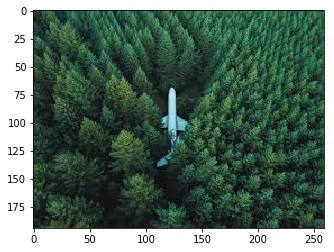

not human


/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:45: RuntimeWarning: invalid value encountered in less


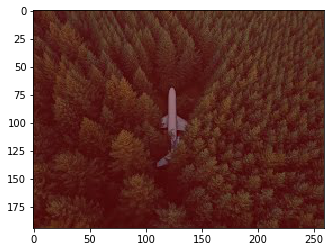

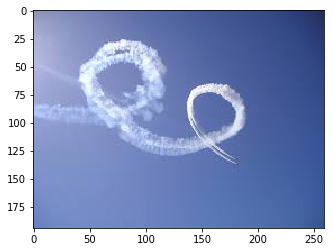

not human


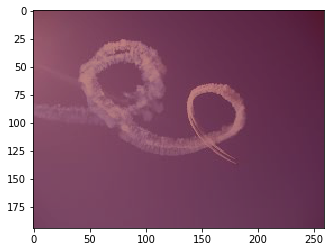

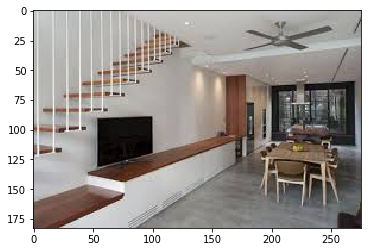

not human


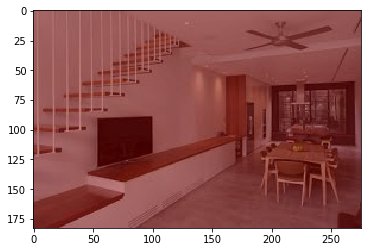

In [86]:
quick_test(model, train_files, 3, "final_conv_layer", "dense_layer")